import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

In [119]:
df = pd.read_csv(r"C:\Users\estef\Documents\Paper 2020\Data Phyton K.csv", parse_dates=['date'], index_col='date')


In [120]:
df.tail()

,desem,infla,Cetes91,pesopromedio
date,,,,
2019-08-01,-0.09,3.16,7.99,19.59
2019-09-01,-0.56,3.00,7.70,19.62
2019-10-01,-0.41,3.02,7.58,19.37
2019-11-01,-0.28,2.97,7.47,19.29
2019-12-01,-0.25,2.83,7.31,19.18


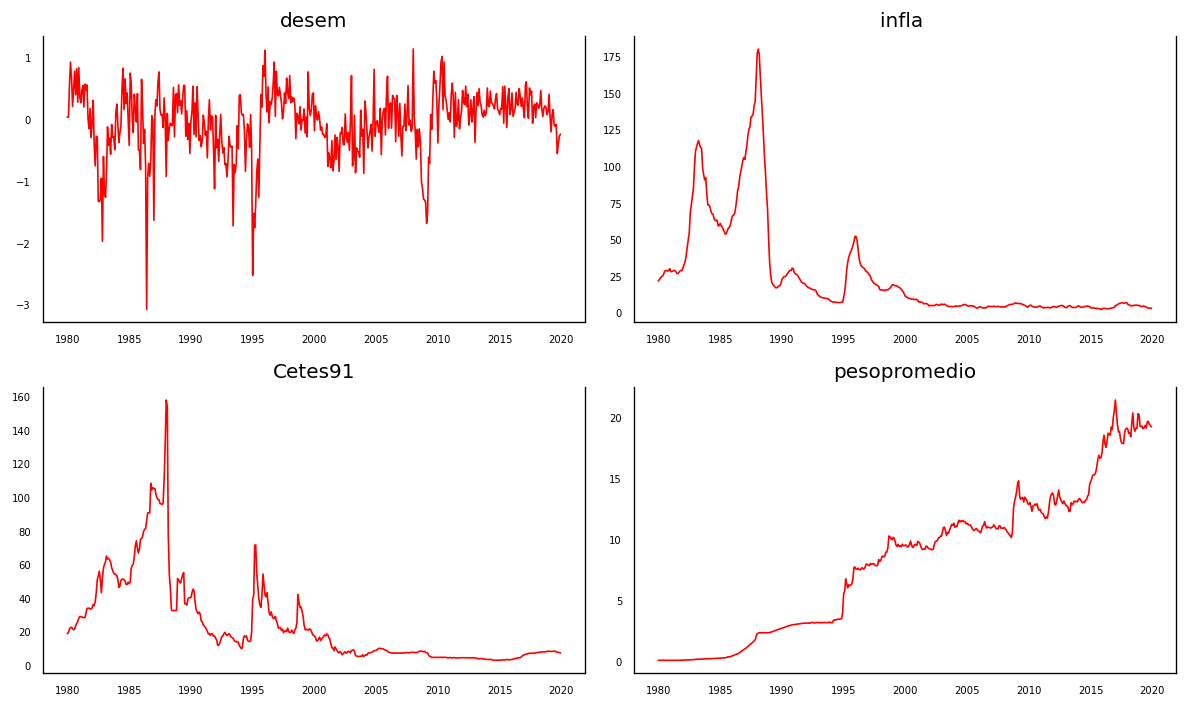

In [121]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [122]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12


In [124]:
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

    

,desem_x,infla _x,Cetes91_x,pesopromedio_x
desem_y,1.0000,0.1294,0.1856,0.0081
infla _y,0.0000,1.0000,0.0000,0.0140
Cetes91_y,0.2372,0.0000,1.0000,0.0025
pesopromedio_y,0.3999,0.8724,0.8174,1.0000


In [60]:
#The row are the Response (Y) and the columns are the predictor series (X).
#For example, if you take the value 0.1294 in (row 1, column 2), it refers to the p-value of infla_x causing desem_y Whereas, the 0.000 in (row 2, column 1) refers to the p-value of desemp_x causing infla_y
#If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).
#P value of 0.0000 es less that the significant level of 0.05
#We can reject the null hypothesis and conclude desemp_x causes infla_y


In [125]:
#Cointegration Test. When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
desem  ::  103.83    > 40.1749   =>   True
infla  ::  42.02     > 24.2761   =>   True
Cetes91 ::  8.82      > 12.3212   =>   False
pesopromedio ::  0.68      > 4.1296    =>   False


In [62]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(476, 4)
(4, 4)


In [63]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [126]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "desem" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6918
 No. Lags Chosen       = 2
 Critical value 1%     = -3.444
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "infla " 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5066
 No. Lags Chosen       = 14
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.1139. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Cetes91" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.


In [65]:
# 1st difference
df_differenced = df_train.diff().dropna()


In [66]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "desem" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.9747
 No. Lags Chosen       = 17
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "infla " 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.9942
 No. Lags Chosen       = 13
 Critical value 1%     = -3.445
 Critical value 5%     = -2.868
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Cetes91" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [67]:
#All the series are now stationary in 1 diff.


In [80]:
#Select the Order (P) of VAR model
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  0.16751772237688836
BIC :  0.34309609038090005
FPE :  1.1823699453934178
HQIC:  0.23657027529864574 

Lag Order = 2
AIC :  -0.0578037908525339
BIC :  0.2587446953751819
FPE :  0.9438524606788032
HQIC:  0.06670139693936433 

Lag Order = 3
AIC :  -0.057877806332398
BIC :  0.40009445479143435
FPE :  0.9438178699031623
HQIC:  0.12226831276576211 

Lag Order = 4
AIC :  -0.03968718676901645
BIC :  0.5601649372078762
FPE :  0.9612106439319476
HQIC:  0.19628918635217707 

Lag Order = 5
AIC :  -0.013963568746603594
BIC :  0.7282269554132788
FPE :  0.9863683470145589
HQIC:  0.2780334150549969 

Lag Order = 6
AIC :  -0.01808666925508018
BIC :  0.8669032600511628
FPE :  0.9824733280386403
HQIC:  0.3301223235573403 

Lag Order = 7
AIC :  -0.005336265208491786
BIC :  1.0229165602753694
FPE :  0.9953107203155543
HQIC:  0.399277184423954 

Lag Order = 8
AIC :  -0.009650850016661883
BIC :  1.1623308673544184
FPE :  0.9913307116519859
HQIC:  0.4515605616037177 

Lag Order = 9
AIC : 

C:\Users\estef\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [69]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,1.542,1.578,4.674,1.556
1,0.2334,0.4122,1.263,0.3038
2,0.001024,0.3227*,1.001,0.1277*
3,-0.0002494,0.4645,0.9998,0.1827
4,0.009558,0.6173,1.010,0.2488
5,0.02859,0.7793,1.029,0.3241
6,0.01922,0.9129,1.020,0.3710
7,0.02420,1.061,1.025,0.4323
8,0.01192,1.192,1.013,0.4763
9,-0.09778,1.225,0.9081,0.4229


In [81]:
#model with 4 lags
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 14, Aug, 2020
Time:                     17:51:50
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.560165
Nobs:                     471.000    HQIC:                  0.196289
Log likelihood:          -2595.93    FPE:                   0.961211
AIC:                   -0.0396872    Det(Omega_mle):        0.834109
--------------------------------------------------------------------
Results for equation desem
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.001364         0.019656            0.069           0.945
L1.desem               -0.561531         0.047471          -11.829           0.000
L1.infla               -0.010842         0.010697   

In [71]:
#Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [129]:
import statsmodels.stats.stattools as sm_tools

In [97]:
#falta hacer esta prueba 

In [130]:
out = durbin_watson(model_fitted.resid)


In [131]:
for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

NameError: name 'adjust' is not defined

In [102]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input
    

4


array([[ 0.08, -0.13,  0.16,  0.07],
       [-0.25, -0.33,  0.04,  0.2 ],
       [-0.02, -0.17, -0.1 , -0.22],
       [ 0.03, -0.62, -0.17,  0.52]])

In [132]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast

,desem_1d,infla _1d,Cetes91_1d,pesopromedio_1d
date,,,,
2019-09-01,-0.073435,-0.435593,-0.890057,0.193250
2019-10-01,0.012200,-0.537007,0.426066,0.017793
2019-11-01,0.049104,-0.211876,0.337102,0.012223
2019-12-01,-0.045159,-0.261555,-0.170396,0.022055


In [137]:
def invert_transformation(df_train, df_forecast, first_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
                df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [140]:
df_results = invert_transformation(df_train, df_forecast, first_diff=True)        


In [141]:
df_results.loc[:, ['desem_1d','infla_1d','Cetes91_1d','pesopromedio_1d']]

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [143]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

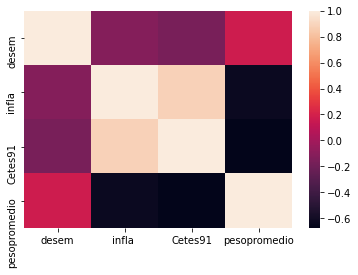

In [144]:
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [114]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.formula.api as sm

%matplotlib inline

In [115]:
df.describe()


,desem,infla,Cetes91,pesopromedio
count,480.000000,480.000000,480.000000,480.000000
mean,-0.048812,24.892312,23.973042,8.188646
std,0.524262,34.354106,25.584176,5.977559
min,-3.080000,2.130000,2.860000,0.020000
25%,-0.290000,4.265000,7.127500,2.652500
50%,0.040000,8.060000,14.580000,9.365000
75%,0.270000,28.005000,33.287500,12.495000
max,1.130000,179.730000,157.630000,21.370000


In [145]:
corr = df.corr()
corr

,desem,infla,Cetes91,pesopromedio
desem,1.000000,-0.120346,-0.162693,0.174199
infla,-0.120346,1.000000,0.886099,-0.628010
Cetes91,-0.162693,0.886099,1.000000,-0.677528
pesopromedio,0.174199,-0.628010,-0.677528,1.000000


SyntaxError: unexpected EOF while parsing (<ipython-input-117-7777ded97e22>, line 2)

In [1]:
$ jupyter nbconvert --to html modelo VAR.ipynb

SyntaxError: invalid syntax (<ipython-input-1-326a17883ea6>, line 1)

In [2]:

jupyter nbconvert --to html modelo VAR.ipynb

SyntaxError: invalid syntax (<ipython-input-2-b6708242e6fc>, line 1)

$ jupyter nbconvert --to html modelo VAR.ipynb